In [53]:
from tensorflow.keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import BatchNormalization


In [2]:
IMAGE_SIZE = [224, 224]

train_path = r'/Users/hexue/pyproject/retina_classification/Retinal Fundus Images/train'
test_path = r'/Users/hexue/pyproject/retina_classification/Retinal Fundus Images/test'
val_path = r'/Users/hexue/pyproject/retina_classification/Retinal Fundus Images/val'

In [5]:
# 创建并冻结 VGG16 模型
vgg16_base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in vgg16_base_model.layers:
    layer.trainable = False


In [6]:

# 创建并冻结 EfficientNetB0 模型
efficientnet_base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in efficientnet_base_model.layers:
    layer.trainable = False

In [7]:

# 创建并冻结 ResNet50 模型
resnet50_base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in resnet50_base_model.layers:
    layer.trainable = False

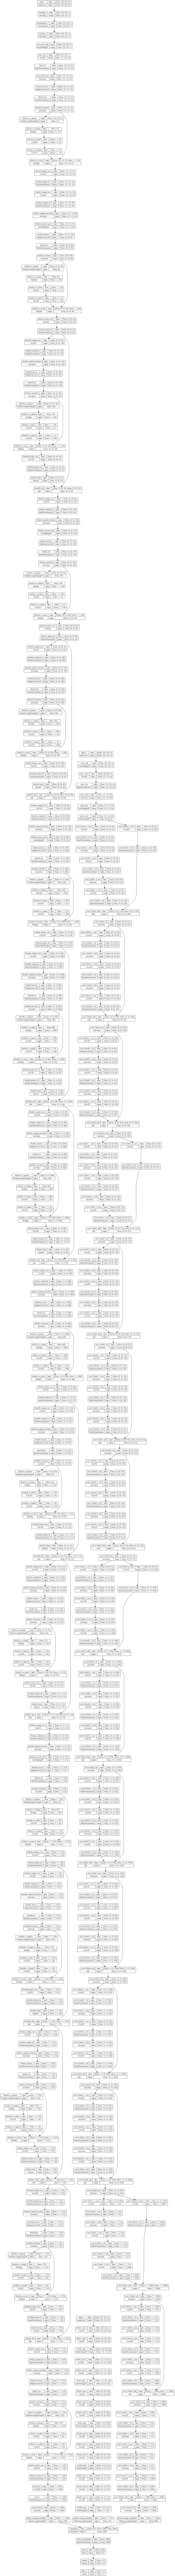

In [8]:

# 构建全连接层进行融合
vgg16_output = vgg16_base_model.output
efficientnet_output = efficientnet_base_model.output
resnet50_output = resnet50_base_model.output

merged_output = Concatenate()([GlobalAveragePooling2D()(vgg16_output),
                               GlobalAveragePooling2D()(efficientnet_output),
                               GlobalAveragePooling2D()(resnet50_output)])

# 添加 BatchNormalization 层（这里只保留一个）
x = BatchNormalization()(merged_output)

# 添加全连接层
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006))(x)

# 添加 Dropout 层
x = Dropout(rate=0.45, seed=123)(x)

# 输出层
output = Dense(11, activation='softmax')(x)

# 创建 Ensemble 模型
ensemble_model = Model(inputs=[vgg16_base_model.input, efficientnet_base_model.input, resnet50_base_model.input],
                       outputs=output)

# 编译模型
ensemble_model.compile(optimizer=tf.keras.optimizers.legacy.Adamax(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# 输出模型结构图
plot_model(ensemble_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [42]:

# 数据生成器和加载数据
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True)


train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(directory=train_path,
target_size = (224,224),
batch_size = 32,
class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(directory=test_path,
target_size = (224,224),
batch_size = 32,
class_mode = 'categorical')
val_set = test_datagen.flow_from_directory(directory=val_path,
target_size = (224,224),
batch_size = 32,
class_mode = 'categorical')




Found 20077 images belonging to 11 classes.
Found 1236 images belonging to 11 classes.
Found 433 images belonging to 11 classes.


In [48]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    print(y_true)
    print(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

1/1 [==============================] - 4s 4s/step
          Filename                Predicted Class                True Class           Probability   

1.Dry AMD/Dry AMD102_left_0_9943.jpeg         3.Mild DR                   1.Dry AMD              0.2037

1.Dry AMD/Dry AMD102_left_0_9943.jpeg 3.Mild DR 1.Dry AMD 0.20373699
1.Dry AMD/Dry AMD102_right_0_3112.jpeg         3.Mild DR                   1.Dry AMD              0.1699

1.Dry AMD/Dry AMD102_right_0_3112.jpeg 3.Mild DR 1.Dry AMD 0.16994289
1.Dry AMD/Dry AMD102_right_0_6903.jpeg         3.Mild DR                   1.Dry AMD              0.1760

1.Dry AMD/Dry AMD102_right_0_6903.jpeg 3.Mild DR 1.Dry AMD 0.17600249
1.Dry AMD/Dry AMD152_right_0_4137.jpeg         3.Mild DR                   1.Dry AMD              0.1856

1.Dry AMD/Dry AMD152_right_0_4137.jpeg 3.Mild DR 1.Dry AMD 0.18564777
1.Dry AMD/Dry AMD168_right_0_2178.jpeg         3.Mild DR                   1.Dry AMD              0.1691

1.Dry AMD/Dry AMD168_right_0_2178.jpeg 3

ValueError: Found input variables with inconsistent numbers of samples: [1236, 32]

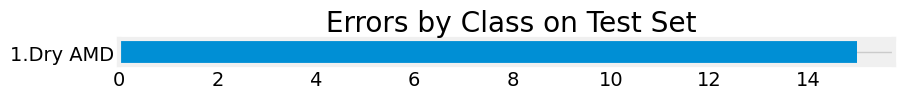

In [49]:
import os
from sklearn.metrics import confusion_matrix, classification_report
length=len(test_set)
subject='eye disease'
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
working_dir = r'./'
print_code=10
# 获取一个 batch 的数据
inputs, targets = next(training_set)
preds=ensemble_model.predict([inputs, inputs, inputs], steps=test_steps, verbose=1) 
print_info( test_set, preds, print_code, working_dir, subject )  


In [52]:
m = ensemble_model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  batch_size=128,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  shuffle=False,
  initial_epoch=0
)

Epoch 1/20


2023-12-15 15:13:38.467332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


TypeError: 'NoneType' object is not callable

In [38]:


x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(11, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
#for windows
#model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
#for mac
model.compile(tf.keras.optimizers.legacy.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/20


2023-12-15 13:14:41.492721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


ValueError: in user code:

    File "/Users/hexue/anaconda3/envs/cvenv/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/hexue/anaconda3/envs/cvenv/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hexue/anaconda3/envs/cvenv/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/hexue/anaconda3/envs/cvenv/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/hexue/anaconda3/envs/cvenv/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/hexue/anaconda3/envs/cvenv/lib/python3.11/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


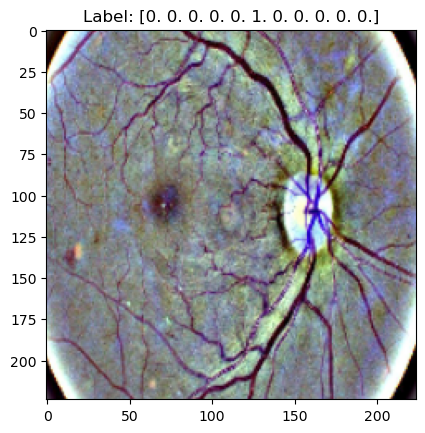

图像数据的维度: (32, 224, 224, 3)
标签数据的维度: (32, 11)


In [12]:
import matplotlib.pyplot as plt

# 从生成器中获取一个批次的数据
images, labels = next(training_set)

# 显示其中的一张图像（假设 batch_size 是 32）
plt.imshow(images[0])
plt.title(f'Label: {labels[0]}')
plt.show()
# 打印图像数据的维度
print("图像数据的维度:", images.shape)

# 打印标签数据的维度
print("标签数据的维度:", labels.shape)

In [9]:
m = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  batch_size=128,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  shuffle=False,
  initial_epoch=0
)

Epoch 1/20


2023-12-13 17:11:49.946911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-13 17:11:49.990583: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


114/628 [====>.........................] - ETA: 1:49:50 - loss: 8.9904 - accuracy: 0.4172


KeyboardInterrupt



In [10]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    print(y_true)
    print(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [11]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

1/1 [==============================] - 3s 3s/step
          Filename                Predicted Class                True Class           Probability   

1.Dry AMD/Dry AMD102_left_0_9315.jpeg         3.Mild DR                   1.Dry AMD              0.6531

1.Dry AMD/Dry AMD102_left_0_9315.jpeg 3.Mild DR 1.Dry AMD 0.6530552
1.Dry AMD/Dry AMD102_left_0_9943.jpeg         3.Mild DR                   1.Dry AMD              0.3644

1.Dry AMD/Dry AMD102_left_0_9943.jpeg 3.Mild DR 1.Dry AMD 0.3643619
1.Dry AMD/Dry AMD102_right_0_116.jpeg         3.Mild DR                   1.Dry AMD              0.4724

1.Dry AMD/Dry AMD102_right_0_116.jpeg 3.Mild DR 1.Dry AMD 0.47237563
1.Dry AMD/Dry AMD102_right_0_3112.jpeg         7.Cataract                  1.Dry AMD              0.9964

1.Dry AMD/Dry AMD102_right_0_3112.jpeg 7.Cataract 1.Dry AMD 0.9963586
1.Dry AMD/Dry AMD102_right_0_4731.jpeg         7.Cataract                  1.Dry AMD              0.6185

1.Dry AMD/Dry AMD102_right_0_4731.jpeg 7.Catar

ValueError: Found input variables with inconsistent numbers of samples: [1236, 32]

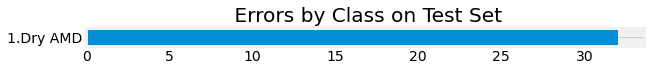

In [12]:
import os
from sklearn.metrics import confusion_matrix, classification_report
length=len(test_set)
subject='eye disease'
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
working_dir = r'./'
print_code=10
preds=model.predict(test_set, steps=test_steps, verbose=1) 
print_info( test_set, preds, print_code, working_dir, subject )  

In [ ]:
model.predict(test_set)

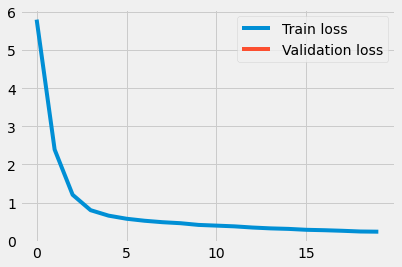

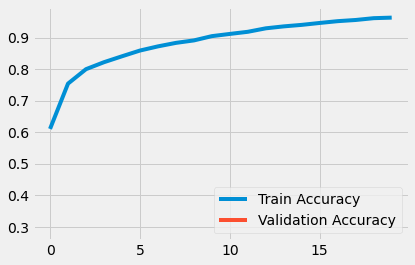

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(m.history['loss'], label='Train loss')
plt.plot(m.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(m.history['accuracy'], label='Train Accuracy')
plt.plot(m.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [14]:
test_loss, test_acc = model.evaluate(test_set)
print("Test ACC: ", round(test_acc, 2))

39/39 [==============================] - 17s 433ms/step - loss: 3.0190 - accuracy: 0.1837
Test ACC:  0.18
